In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import json
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

***Import & Analize Data***

In [2]:
#Import data from json file and create a list

data = []
with open('Digital_Music_5.json') as f:
    for line in f:
        data.append(json.loads(line))

#Create a dataframe with the columns that are interesting for this exercise
#Columns left out: 'helpful', 'reviewTime', 'reviewerID','reviewerName'
names = ["overall", "reviewText"]
amazonraw = pd.DataFrame(data, columns=names)
amazonraw['overall'] = amazonraw['overall'].astype(int)
amazonraw.head()

,overall,reviewText
0,5,"It's hard to believe ""Memory of Trees"" came ou..."
1,5,"A clasically-styled and introverted album, Mem..."
2,5,I never thought Enya would reach the sublime h...
3,5,This is the third review of an irish album I w...
4,4,"Enya, despite being a successful recording art..."


In [3]:
#Analyse the dataset: types, length of the dataframe and NaN
amazonraw.info()
amazonraw.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 2 columns):
overall       64706 non-null int32
reviewText    64706 non-null object
dtypes: int32(1), object(1)
memory usage: 758.4+ KB


overall        int32
reviewText    object
dtype: object

***Build Sentiment Scores and Categories***

In [4]:
amazonraw.overall.describe()

count    64706.000000
mean         4.222514
std          1.086081
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [5]:
#Change the Overall variable into a categorical variable
#Ratings equal or lower than 3 have been considered negative as the mean is 4.25.
#The hypothesis is that although the abovmentioned ratings could be considered positive they are negative

amazonraw.loc[amazonraw['overall'] <= 3, 'Sentiment'] = 0
amazonraw.loc[amazonraw['overall'] >=4 , 'Sentiment'] = 1
amazonraw.loc[amazonraw['Sentiment'] == 0, 'Category'] ='Negative'
amazonraw.loc[amazonraw['Sentiment'] == 1, 'Category'] = 'Positive'

In [6]:
#Count the each of the categories

a = amazonraw['Category'].value_counts('Positive')
b = pd.value_counts(amazonraw['Category'].values, sort=False)

print('Number of ocurrencies:\n', b)
print('\n')
print('Frequency of each value:\n', a)

Number of ocurrencies:
 Positive    52116
Negative    12590
dtype: int64


Frequency of each value:
 Positive    0.805428
Negative    0.194572
Name: Category, dtype: float64


In [7]:
#Downsample majority class (due to computational restrictions we downsample the majority instead of upsampling the minority)

# Separate majority and minority classes
amazon_majority = amazonraw[amazonraw.Sentiment == 1]
amazon_minority = amazonraw[amazonraw.Sentiment == 0]
 
# Downsample mairlinesass
amazon_majority_downsampled = resample(amazon_majority, replace=False, n_samples=12590, random_state=123) 
 
# Combine minority class with downsampled majority class
amazon = pd.concat([amazon_majority_downsampled, amazon_minority])
 
# Display new class counts
amazon.Category.value_counts()

Negative    12590
Positive    12590
Name: Category, dtype: int64

Text(0.5,1,'Categories in the downsampled dataset')

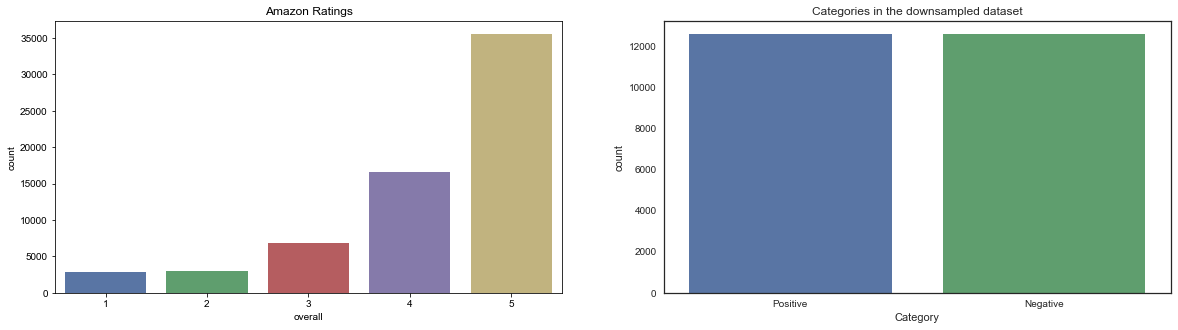

In [8]:
#Graphical representation of the positive and negative reviews

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)

sns.set(style="white")
ax = sns.countplot(x="overall", data=amazonraw)
plt.title('Amazon Ratings')

plt.subplot(1, 2, 2)
sns.set(style="white")
ax = sns.countplot(x="Category", data=amazon)
plt.title('Categories in the downsampled dataset')

In [9]:
#Create new dataframe that has the Categories, Overall scores, Sentiment and ReviewText
names = ['Category',"overall",'Sentiment', "reviewText"]
amazon1 = pd.DataFrame(amazon, columns=names)
amazon.head()

,overall,reviewText,Sentiment,Category
59643,5,This is a great song that will stand the test ...,1.0,Positive
55386,5,I am ashamed to say that such a high rating on...,1.0,Positive
29299,4,"Mobb deep have never disapointed fans , with a...",1.0,Positive
61457,4,I first learned of Sharon Van Etten when Rolli...,1.0,Positive
41719,4,In a similar line as contemporary acts The Vin...,1.0,Positive


In [10]:
#Lines are reshuffled and 50% of the dataset is used to reduce the computing effort
amazon2 = amazon1.sample(frac=1, random_state=7)

In [11]:
#Predictors and prediced variables are formed

X = amazon2['reviewText']
y = amazon2['Sentiment']

#Split the data set into train and test 70/30
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.3, random_state=135)

#KFold for cross validation analysis
kf = KFold(5)

### Bag of Words ###

In [12]:
#Analysis starts with Bag of Words and common English words are extracted

vect = CountVectorizer(analyzer = 'word', stop_words='english').fit(X_train)

X_trainvec = vect.transform(X_train)
X_testvec = vect.transform(X_test)

In [13]:
#Count the number of english words and take a look at the type of words that are extracted

print("Number of stop words is :", len(ENGLISH_STOP_WORDS), "\n")
print("Examples: ", list(ENGLISH_STOP_WORDS)[::10])

Number of stop words is : 318 

Examples:  ['ourselves', 'see', 'but', 'will', 'latterly', 'de', 'noone', 'never', 'that', 'except', 'hereby', 'thence', 'them', 'here', 'it', 'off', 'seem', 'first', 'between', 'together', 'seemed', 'become', 'whereby', 'last', 'she', 'whereas', 'many', 'nevertheless', 'moreover', 'whose', 'himself', 'over']


In [14]:
#Take a look at the features identified by bag of words

features_names = vect.get_feature_names()
print(len(features_names))
print("\n")
# print first 20 features
print(features_names[:20])
print("\n")
# print last 20 features
print(features_names[-20:])

59374


['00', '000', '000x', '0051', '006', '007', '00am', '00s', '01', '01so', '02', '02604', '029', '03', '0304', '04', '0403', '047', '05', '054']


['zulu', 'zumba', 'zune', 'zup', 'zutons', 'zwan', 'zwizany', 'zydeco', 'zygote', 'zz', 'zztop', 'zzz', 'zzzzzzzz', 'zzzzzzzzz', 'zzzzzzzzzz', 'zzzzzzzzzzz', 'zzzzzzzzzzzzz', 'zzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz']


In [15]:
#Size of the X_trainvector sparse matrix
print(X_trainvec.shape)
X_trainvec

(17626, 59374)


<17626x59374 sparse matrix of type '<class 'numpy.int64'>'
	with 1288564 stored elements in Compressed Sparse Row format>

In [16]:
#Check the size of the y_train vector to avoid problems when running the logistic regression model
y_train.shape

(17626,)

***Bernoulli***

In [17]:
# Initialize and fit the model.

l3 = BernoulliNB()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(l3, param_grid, scoring='roc_auc', refit=True, cv=kf)

l3 = grid.fit(X_trainvec, y_train)

# Predict on training set
predtrain_y = grid.predict(X_trainvec)

In [18]:
#Evaluation of model (training set)
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain_y, target_names=target_names))

confusion = confusion_matrix(y_train, predtrain_y)
print(confusion)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(l3,X_trainvec,y_train,cv=kf).mean(),train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.58      0.94      0.72      8812
        1.0       0.84      0.32      0.46      8814

avg / total       0.71      0.63      0.59     17626

[[8262  550]
 [6017 2797]]
Training set accuracy: 0.7830242894762277
Percent Type I errors: 0.031203903324634064
Percent Type II errors: 0.34137070237149664




In [19]:
#Predicting on the test set

l3 = BernoulliNB()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(l3, param_grid, scoring='roc_auc', refit=True, cv=kf)

l3 = grid.fit(X_testvec, y_test)

# Predict on training set
predtest_y = grid.predict(X_testvec)

In [20]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(l3,X_testvec,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.58      0.97      0.72      3778
        1.0       0.91      0.29      0.44      3776

avg / total       0.74      0.63      0.58      7554

[[3664  114]
 [2690 1086]]
Training set accuracy: 0.796462037665769
Percent Type I errors: 0.015091342335186657
Percent Type II errors: 0.356102727032036




***Logistic Model***

In [21]:
# Initialize and fit the model.

lr = LogisticRegression(class_weight='balanced')

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=kf)

lr = grid.fit(X_trainvec, y_train)

# Predict on training set
predtrain_y = lr.predict(X_trainvec)

In [22]:

target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain_y, target_names=target_names))

confusion = confusion_matrix(y_train, predtrain_y)
print(confusion)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(lr,X_trainvec,y_train,cv=kf).mean(),train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.92      0.93      0.93      8812
        1.0       0.93      0.92      0.93      8814

avg / total       0.93      0.93      0.93     17626

[[8165  647]
 [ 665 8149]]
Training set accuracy: 0.8654090672647274
Percent Type I errors: 0.03670713718370589
Percent Type II errors: 0.03772835583796664




In [23]:
#Once the model has been trained test it on the test dataset
lr = grid.fit(X_testvec, y_test)

# Predict on test set
predtest_y = grid.predict(X_testvec)

In [24]:

target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(lr,X_testvec,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94      3778
        1.0       0.94      0.94      0.94      3776

avg / total       0.94      0.94      0.94      7554

[[3569  209]
 [ 215 3561]]
Training set accuracy: 0.8366741973989711
Percent Type I errors: 0.027667460947842202
Percent Type II errors: 0.028461742123378344




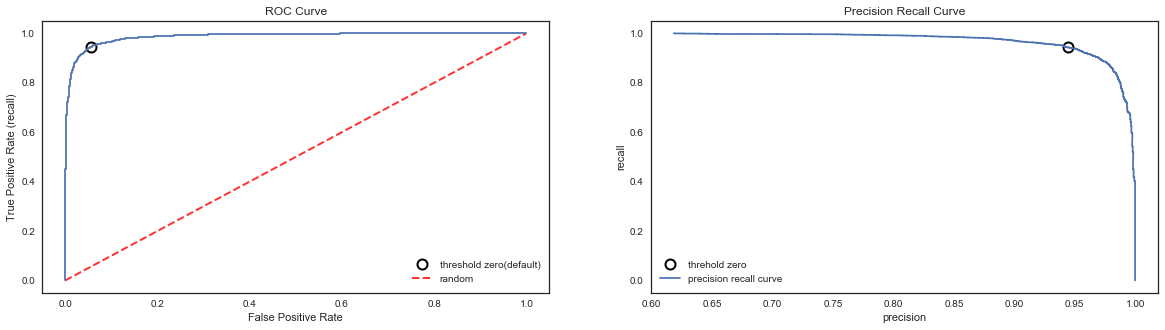

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# find threshold closest to zero:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_testvec))

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero(default)', fillstyle='none', c='k', mew=2)
plt.plot([0,1], linestyle='--', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC Curve')

precision, recall, thresholds = precision_recall_curve(y_test, grid.decision_function(X_testvec))

plt.subplot(1, 2, 2)
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threhold zero", fillstyle="none", c="k", mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("Precision Recall Curve")
plt.legend(loc="best")

***TFIDF***

In [26]:

vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english',
                        ngram_range = (1,2)
                       ).fit(X_train)

X_train_vectorized = vect2.transform(X_train)
X_test_vectorized = vect2.transform(X_test)

In [27]:
features_names = vect2.get_feature_names()
print(len(features_names))

11926


***Logistic Model***

In [28]:
# Initialize and fit the model.

lr2 = LogisticRegression(class_weight='balanced')

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(lr2, param_grid, scoring='roc_auc', refit=True, cv=kf)

lr2 = grid.fit(X_train_vectorized, y_train)

# Predict on training set
predtrain2_y = lr2.predict(X_train_vectorized)

In [29]:
#Training Scores
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain2_y, target_names=target_names))

confusion = confusion_matrix(y_train, predtrain2_y)
print(confusion)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain2_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(lr2,X_train_vectorized,y_train,cv=kf).mean(),train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.89      0.87      0.88      8812
        1.0       0.87      0.89      0.88      8814

avg / total       0.88      0.88      0.88     17626

[[7655 1157]
 [ 976 7838]]
Training set accuracy: 0.887109776407718
Percent Type I errors: 0.06564166572109384
Percent Type II errors: 0.05537274480880518




In [30]:
#Once the model has been trained test it on the test dataset
lr2 = grid.fit(X_test_vectorized, y_test)

# Predict on test set
predtest2_y = lr2.predict(X_test_vectorized)

In [31]:
#Evaluate model (test set)
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest2_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest2_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest2_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(lr2,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.89      0.88      0.89      3778
        1.0       0.88      0.89      0.89      3776

avg / total       0.89      0.89      0.89      7554

[[3336  442]
 [ 397 3379]]
Test set accuracy: 0.860150950189537
Percent Type I errors: 0.058512046597828965
Percent Type II errors: 0.05255493778130792




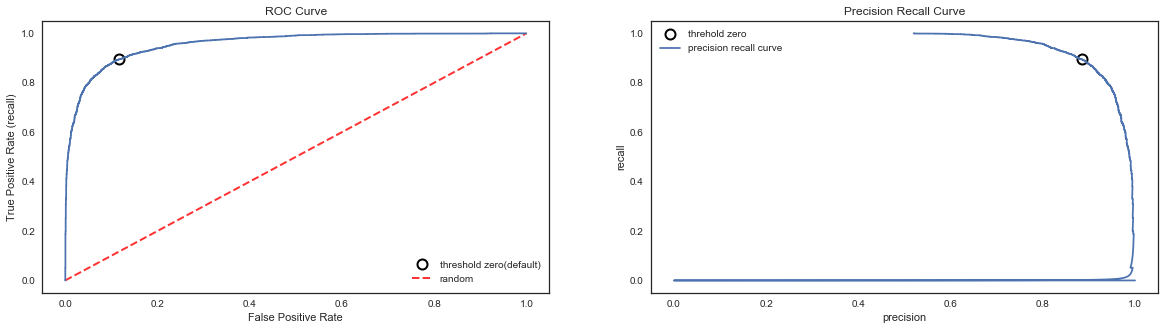

In [32]:
#AUC and precision-recall curves

# find threshold closest to zero:
fpr, tpr, thresholds = roc_curve(y_test, lr2.decision_function(X_test_vectorized))

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold zero(default)', fillstyle='none', c='k', mew=2)
plt.plot([0,1], linestyle='--', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC Curve')

precision, recall, thresholds = precision_recall_curve(y_test, lr2.decision_function(X_test_vectorized))

plt.subplot(1, 2, 2)
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threhold zero", fillstyle="none", c="k", mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("Precision Recall Curve")
plt.legend(loc="best")


***Bernouilli Model***

In [33]:
# Initialize and fit the model.

l3 = BernoulliNB()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(l3, param_grid, scoring='roc_auc', refit=True, cv=kf)

l3 = grid.fit(X_train_vectorized, y_train)

# Predict on training set
predtrain3_y = grid.predict(X_train_vectorized)

In [34]:
#Evaluate Model (training set)

target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain_y, target_names=target_names))

confusion = confusion_matrix(y_train, predtrain_y)
print(confusion)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(l3,X_train_vectorized,y_train,cv=kf).mean(),train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.92      0.93      0.93      8812
        1.0       0.93      0.92      0.93      8814

avg / total       0.93      0.93      0.93     17626

[[8165  647]
 [ 665 8149]]
Training set accuracy: 0.8018090261119195
Percent Type I errors: 0.03670713718370589
Percent Type II errors: 0.03772835583796664




In [35]:
# Predict on the test data set

l3 = BernoulliNB()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(l3, param_grid, scoring='roc_auc', refit=True, cv=kf)

l3 = grid.fit(X_test_vectorized, y_test)

# Predict on training set
predtest3_y = grid.predict(X_test_vectorized)

In [36]:
#Evaluation of the model (testing)

target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest3_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest3_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest3_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(l3,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.72      0.89      0.79      3778
        1.0       0.85      0.65      0.74      3776

avg / total       0.78      0.77      0.76      7554

[[3358  420]
 [1337 2439]]
Training set accuracy: 0.8083484864545237
Percent Type I errors: 0.05559968228752978
Percent Type II errors: 0.17699232194863648




***KNN model***

In [37]:
# Initialize and fit the model
KNN = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 3, 5]}

grid = GridSearchCV(KNN, param_grid, scoring='roc_auc', refit=True, cv=kf)

KNN = grid.fit(X_train_vectorized, y_train)

# Predict on training set
predtrain3_y = grid.predict(X_train_vectorized)

In [38]:
#Evaluate model on the training set
target_names = ['0.0', '1.0']
print(classification_report(y_train, predtrain3_y, target_names=target_names))

confusion = confusion_matrix(y_train, predtrain3_y)
print(confusion)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrain3_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(KNN,X_train_vectorized,y_train,cv=kf).mean(),train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

        0.0       0.75      0.84      0.79      8812
        1.0       0.82      0.72      0.77      8814

avg / total       0.79      0.78      0.78     17626

[[7438 1374]
 [2488 6326]]
Training set accuracy: 0.6709910940534166
Percent Type I errors: 0.07795302394190401
Percent Type II errors: 0.14115511176670828




In [39]:
# Initialize and fit the model
KNN = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 3, 5]}

grid = GridSearchCV(KNN, param_grid, scoring='roc_auc', refit=True, cv=kf)

KNN = grid.fit(X_test_vectorized, y_test)

# Predict on training set
predtest3_y = grid.predict(X_test_vectorized)

In [40]:
#Evaluate model on the training set
target_names = ['0.0', '1.0']
print(classification_report(y_test, predtest3_y, target_names=target_names))

confusion = confusion_matrix(y_test, predtest3_y)
print(confusion)

# Accuracy tables.
table_test = pd.crosstab(y_test, predtest3_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Training set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(KNN,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

        0.0       0.73      0.84      0.78      3778
        1.0       0.82      0.69      0.75      3776

avg / total       0.77      0.77      0.77      7554

[[3188  590]
 [1172 2604]]
Training set accuracy: 0.6561079182800065
Percent Type I errors: 0.07810431559438707
Percent Type II errors: 0.15514958962139264




***Random Forest***

In [41]:
# Train model
rf = RandomForestClassifier()
rf.fit(X_train_vectorized, y_train)
rf.fit(X_test_vectorized, y_test)

# Predict on training set
predtrainrf_y = rf.predict(X_train_vectorized)
predtestrf_y = rf.predict(X_test_vectorized)

In [42]:
#Training Scores
target_names = ['0', '1']
print(classification_report(y_train, predtrainrf_y, target_names=target_names))
cnf = confusion_matrix(y_train, predtrainrf_y)
print(cnf)

# Accuracy tables.
table_train = pd.crosstab(y_train, predtrainrf_y, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

print((
    'Training set accuracy:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(cross_val_score(rf,X_train_vectorized,y_train,cv=kf).mean(),train_tI_errors, train_tII_errors))

             precision    recall  f1-score   support

          0       0.68      0.78      0.73      8812
          1       0.74      0.64      0.69      8814

avg / total       0.71      0.71      0.71     17626

[[6830 1982]
 [3166 5648]]
Training set accuracy:0.713718572871033
Percent Type I errors: 0.11244752070804494
Percent Type II errors: 0.1796210144105299




In [43]:
#Test Scores
target_names = ['0', '1']
print(classification_report(y_test, predtestrf_y, target_names=target_names))
cnf = confusion_matrix(y_test, predtestrf_y)
print(cnf)

table_test = pd.crosstab(y_test, predtestrf_y, margins=True)

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Test set accuracy:{}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(cross_val_score(rf,X_test_vectorized,y_test,cv=kf).mean(),test_tI_errors, test_tII_errors))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3778
          1       1.00      0.98      0.99      3776

avg / total       0.99      0.99      0.99      7554

[[3767   11]
 [  73 3703]]
Test set accuracy:0.7005553972852503
Percent Type I errors: 0.0014561821551495897
Percent Type II errors: 0.009663754302356367


In the amazon reviews analysis the digital music dataset has been used. To create both categories, ratings 1-3 have been included as negative and 4-5 as positive. This has been done because in the raw data, ratings are skewed to the positive side being the average around 4.0. Data once categorized has been downsampled to reduce the biased towards the positive reviews of the models that have been run. 

To build up the features the bag of words and the TFIDF has been used. In both cases, stop words in English have been extracted so that the number of features is reduced. From the bag of words, 59374 features were built. Additionally, only those that appear in more than 20 reviews have been used. The TFIDF was applied considering n-grams (1,3) and the number of features was reduced to 11926.

Models used have been Naïve-Bayes, Random Forest, KNN, and logistics models in a 70\30 split of the dataset (train, test). Results are improved in all cases when TFIDF is used to build the features. From all the models, logistics regression is the one that is better when predicting with an accuracy of 86%. 

To avoid bias on the classifier two measures have been taken. The first one is to downsample the majority so that the risk of overfitting the positive sentiment is reduced. Additionally, instead of working on increasing the accuracy, the measure that has been used is auc-roc so that both precision and recall are balanced. Hence, the logistic regression classifier works on both categorires. 